In [19]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

### Gauss quadrature

The quadrature nodes and weights can be computed by solving the eigensystem

$$ J_n = \begin{bmatrix} \alpha_0 & \sqrt{\beta_1} \\ \sqrt{\beta_1} & \alpha_1 & \sqrt{\beta_2} \\ & \ddots & \ddots \\ & & \sqrt{\beta_{n}} & \alpha_{n} \end{bmatrix}. $$

The quadrature nodes are the eigenvalues of $J_n$ and the weights are obtained from the first component of the eigenvectors.


The coefficients $\alpha_k$ and $\beta_k$ come from the three-term recursion of the underlying orthogonal polynomials. That is, 
 $$ \phi_{k+1}(x) = x\phi_k(x) - \alpha_k \phi_k(x) - \beta_k\phi_{k-1}(x) \qquad \phi_{-1}(x) = 0, \phi_0(x) = 1.$$
Furthermore, $\beta_0 = \langle 1, 1\rangle$.

### Gauss-Legendre polynomials
For Legendre polynomials $\alpha_k = 0$, for $k=0,1,\dots$. Also $\beta_0 = 2$, $\beta_k = \frac{k^2}{4k^2-1}$ for $k=1,2,3,\dots$. 

In [20]:
def gauss_leg(n):
    
    #Setup terms corresponding to the recurrence
    k = np.arange(1,n+1)
    beta = k**2/(4*k**2-1)
    
    #Set up Jacobi matrix and compute its eigendecomposition
    J = np.diag(np.sqrt(beta),-1) + np.diag(np.sqrt(beta),1)
    l, v = np.linalg.eigh(J)
    
    #Compute weights and nodes
    xk = l
    beta0 = 2
    wk = beta0*v[0,:]**2./np.apply_along_axis(lambda x: np.linalg.norm(x)**2., 0, v)
    
    return wk, xk 

2.0000000000000004


Text(0.5, 1.0, 'Weights')

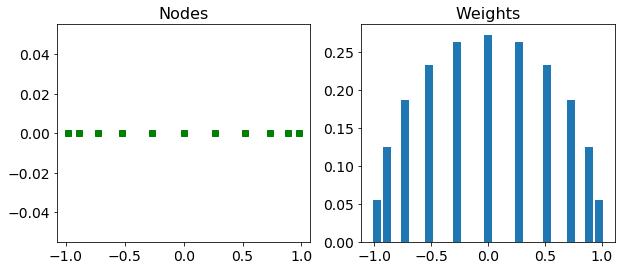

In [21]:
wk, xk = gauss_leg(10)
print(np.sum(wk))
f, (ax1,ax2) = plt.subplots(1,2, figsize = (10,4))
ax1.plot(xk,0*xk, 'gs')
ax1.set_title('Nodes', fontsize = 16)
ax2.bar(xk, wk, width = 0.07)
ax2.set_title('Weights', fontsize = 16)

#### Example 1: Gauss-Legendre on [-1,1]

Want to compute the integral 
$$ I = \int_{-1}^1 \left( 10e^{-50|x|} - \frac{0.01}{(x-0.5)^2 + 0.001} + 5\sin(5x) \right) dx .$$ 

Text(0.5, 1.0, 'Integrand')

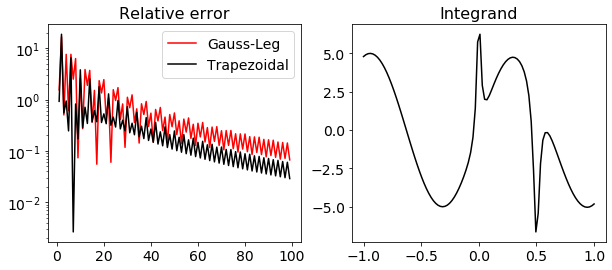

In [22]:
f1 = lambda x: 10*np.exp(-50*abs(x)) - 0.01/((x-0.5)**2. + 0.001) + 5*np.sin(5*x)
I1 = -0.56681975015

from scipy.integrate import simps, trapz
a = -1; b = 1
err_g = []
err_t = []
for n in range(1,100):
    #Compute weights on [-1,1]
    wk, xk = gauss_leg(n)

    
    val = np.sum(wk*f1(xk))
    err_g.append(np.abs(val-I1)/np.abs(I1))
    
    # Compare with Simpson's
    h = (b-a)/n
    xj = a + np.arange(n+1)*h
    val = trapz(f1(xj), xj, h)
    err_t.append(abs(val-I1)/abs(I1))

f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4))
ax1.semilogy(range(1,100), err_g, 'r-', range(1,100), err_t, 'k-')
ax1.legend(('Gauss-Leg', 'Trapezoidal'), fontsize = 14)
ax1.set_title('Relative error', fontsize = 16)
ax2.plot(np.linspace(-1,1,100), f1(np.linspace(-1,1,100)), 'k-')
ax2.set_title('Integrand', fontsize = 16)

#### Example 2: Gauss-Legendre on [a,b]

Want to compute the integral 
$$ I = \int_1^8 \frac{\log x}{x} dx, $$
which has the exact value $I = (\log 8)^2/2.$ Given the Gauss quadrature nodes and weights $(x_k, w_k)$ corresponding to $[-1,1]$, to convert to $[a,b]$ we have to 
+ Change $x_k \leftarrow a + \frac{b-a}{2}(x_k + 1)$
+ Change $w_k \leftarrow \frac{b-a}{2} w_k$

Text(0.5, 1.0, 'Integrand')

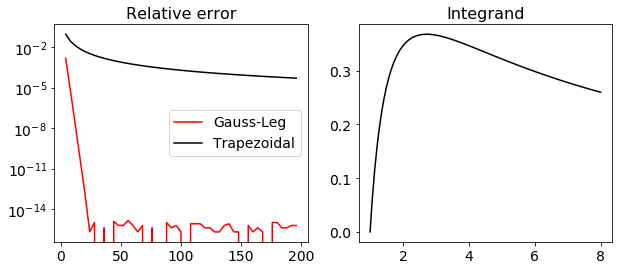

In [23]:
f2 = lambda x: np.log(x)/x
I2 = np.log(8)**2./2.

a = 1; b = 8;

errt = []
errg = []
nlst = range(4,200,4)
for n in nlst:
    h = (b-a)/n
    xj = a + np.arange(n+1)*h
    
    #Trapezoidal rule
    val = trapz(f2(xj), xj, h)
    errt.append(abs(val-I2)/abs(I2))
    
    #Gauss Legendre
    wk, xk = gauss_leg(n)
    wk = (b-a)*wk/2
    xk = a + (b-a)*(xk+1)/2
    val = np.sum(wk*f2(xk))
    errg.append(abs(val-I2)/abs(I2))
        
f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4))
ax1.semilogy(nlst, errg, 'r-', nlst, errt, 'k-')
ax1.legend(('Gauss-Leg', 'Trapezoidal'), fontsize = 14)
ax1.set_title('Relative error', fontsize = 16)
ax2.plot(np.linspace(a,b,100), f2(np.linspace(a,b,100)), 'k-')
ax2.set_title('Integrand', fontsize = 16)

#### Example 3: Gauss-Legendre vs Trapezoidal on periodic

Text(0.5, 1.0, 'Integrand')

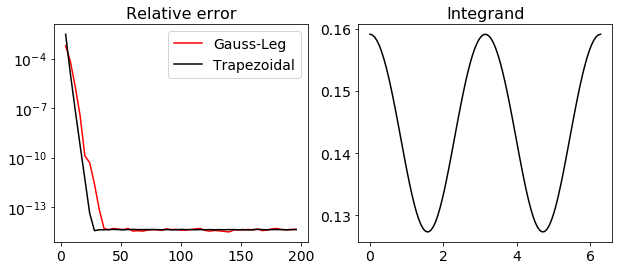

In [24]:
f3 = lambda x: np.sqrt(1-0.36*np.sin(x)**2.)/(2*np.pi)
I3 = 0.90277992777219

a = 0; b = 2*np.pi

errt = []
errg = []
nlst = range(4,200,4)
for n in nlst:
    h = (b-a)/n
    xj = a + np.arange(n+1)*h
    
    #Trapezoidal rule
    val = trapz(f3(xj), xj, h)
    errt.append(abs(val-I3)/abs(I3))
    
    #Gauss Legendre
    wk, xk = gauss_leg(n)
    wk = (b-a)*wk/2
    xk = a + (b-a)*(xk+1)/2
    val = np.sum(wk*f3(xk))
    errg.append(abs(val-I3)/abs(I3))
        

f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4))
ax1.semilogy(nlst, errg, 'r-', nlst, errt, 'k-')
ax1.legend(('Gauss-Leg', 'Trapezoidal'), fontsize = 14)
ax1.set_title('Relative error', fontsize = 16)
ax2.plot(np.linspace(a,b,100), f3(np.linspace(a,b,100)), 'k-')
ax2.set_title('Integrand', fontsize = 16)

### Gauss-Laguerre quadrature

This is a numerical technique for approximating integrals of the form
$$ I(f) = \int_0^\infty e^{-x} f(x) dx. $$

Laguerre polynomials satisfy the recurrence$\alpha_k = 2k+1$, for $k=0,1,\dots$. Also $\beta_0 = 1$, $\beta_k = k^2$ for $k=1,2,3,\dots$. 


In [25]:
def gauss_lag(n):
    
    #Setup terms corresponding to the recurrence
    k = np.arange(1,n+1)
    alpha = 2*k+1
    beta = k**2
    
    #Set up Jacobi matrix and compute its eigendecomposition
    J = np.diag(np.sqrt(beta[:-1]),-1) + np.diag(np.sqrt(beta[:-1]),1) + np.diag(alpha)
    l, v = np.linalg.eigh(J)
    
    #Compute weights and nodes
    xk = l
    beta0 = 1
    wk = beta0*v[0,:]**2./np.apply_along_axis(lambda x: np.linalg.norm(x)**2., 0, v)
    
    return wk, xk 

Text(0.5, 1.0, 'Weights')

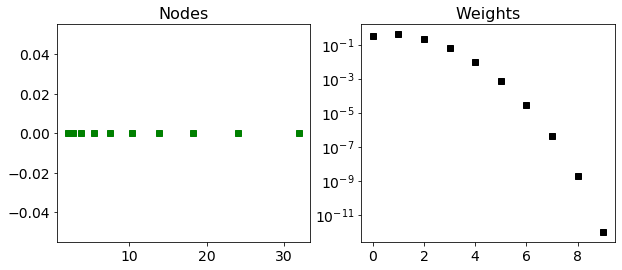

In [33]:
wk, xk = gauss_lag(10)
f, (ax1,ax2) = plt.subplots(1,2, figsize = (10,4))
ax1.plot(xk,0*xk, 'gs')
ax1.set_title('Nodes', fontsize = 16)
ax2.semilogy(wk, 'ks')
ax2.set_title('Weights', fontsize = 16)

Text(0.5, 1.0, 'Integrand')

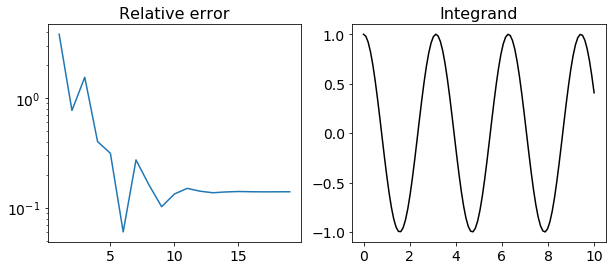

In [32]:
alpha = 2
f4 = lambda x: np.cos(alpha*x)
I4 = 1/(alpha**2. + 1)

err = []
for n in range(1,20):
    wk, xk = gauss_lag(n)
    val = np.sum(wk*f4(xk))
    
    err.append(np.abs(val-I4)/np.abs(I4))

f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4))
ax1.semilogy(range(1,20), err)
ax1.set_title('Relative error', fontsize = 16)
ax2.plot(np.linspace(0,10,100), f4(np.linspace(0,10,100)), 'k-')
ax2.set_title('Integrand', fontsize = 16)

The problem here is that the eigensolver is not very accurate, so the quadrature weights/nodes are not accurate.

Text(0.5, 1.0, 'Integrand')

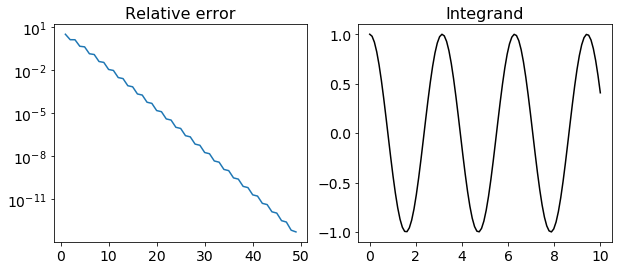

In [28]:
from scipy.special import roots_laguerre

err = []
for n in range(1,50):
    xk, wk = roots_laguerre(n)
    val = np.sum(wk*f4(xk))
    
    err.append(np.abs(val-I4)/np.abs(I4))

f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4))
ax1.semilogy(range(1,50), err)
ax1.set_title('Relative error', fontsize = 16)
ax2.plot(np.linspace(0,10,100), f4(np.linspace(0,10,100)), 'k-')
ax2.set_title('Integrand', fontsize = 16)